<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simulate-experiment-data" data-toc-modified-id="Simulate-experiment-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simulate experiment data</a></span></li><li><span><a href="#Binomial-Distribution" data-toc-modified-id="Binomial-Distribution-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Binomial Distribution</a></span></li><li><span><a href="#Bootstrapping" data-toc-modified-id="Bootstrapping-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bootstrapping</a></span></li></ul></div>

Purpose: hypothesis testing for percentile comparison

# Simulate experiment data

Suppose our data follows parento distribution. We want to compare the 75 percentile for control and treatment group.
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/11/Probability_density_function_of_Pareto_distribution.svg/650px-Probability_density_function_of_Pareto_distribution.svg.png"/>
<center>PDF</center>

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/2a/Cumulative_distribution_function_of_Pareto_distribution.svg/650px-Cumulative_distribution_function_of_Pareto_distribution.svg.png' />
<center>CDF</center>

source: https://en.wikipedia.org/wiki/Pareto_distribution

In [25]:
%pylab inline
import seaborn as sns
from scipy.stats import genpareto

Populating the interactive namespace from numpy and matplotlib


Text(0.5,1,'Distribution Plot')

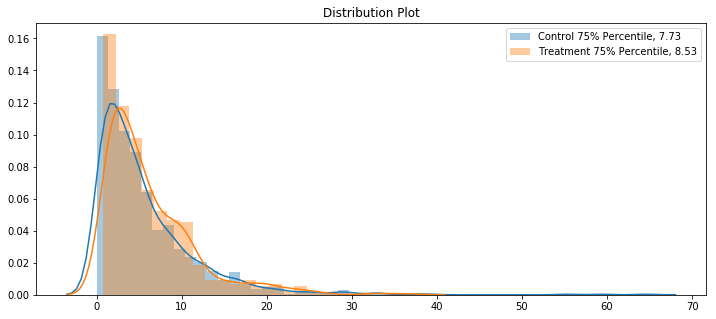

In [75]:
control_n = 1000
treatment_n = 500
control = genpareto.rvs(c,loc=0.1, scale=5, size=control_n)
treatment = genpareto.rvs(c,loc=0.8, scale=5, size=treatment_n)
control_75p = np.percentile(control,75)
treatment_75p = np.percentile(treatment,75)

figure(figsize=(12,5)) 
sns.distplot(control, label='Control 75% Percentile, {p75:.3g}'.format(p75=control_75p))
sns.distplot(treatment, label='Treatment 75% Percentile, {p75:.3g}'.format(p75=treatment_75p))
legend()
title("Distribution Plot")

In [74]:
print("Control variance", np.var(control))
print("Treatment variance", np.var(treatment))

Control variance 37.938945688405994
Treatment variance 30.906261284207346


As you can see, we have more observations in control compared to treatment. Control has a larger variance than teatment but treatment seems to improve 75p. We need to know whether this improvement is stat sig.

# Binomial Distribution

Assuming the CDF of $Y$ is stricting increasing and a density $f_Y$, the $q$-quantile is the value $v$ such that $F_y(v)=q$. Since we know that $Pr(Y_i<=v)=q$ and the observations $Y_i$ are i.i.d, then $$|Y_i <= v| \sim Binomial (n,q)$$

<a href="https://ibb.co/wBZDt4G"><img src="https://i.ibb.co/XjfmHt0/image1.png" alt="image1" border="0"></a><br /><br />

See example: https://stats.stackexchange.com/questions/99829/how-to-obtain-a-confidence-interval-for-a-percentile

In [230]:
# Estimate u and l
import scipy.stats as st
z_score = st.norm.ppf(1-0.025)
binomial_mean_control = 0.75*control_n
binomial_sd_control = sqrt(0.75*(1-0.75)*control_n)

binomial_mean_treatment = 0.75*treatment_n
binomial_sd_treatment = sqrt(0.75*(1-0.75)*treatment_n)

control_l = binomial_mean_control - z_score*binomial_sd_control
control_u = binomial_mean_control + z_score*binomial_sd_control

treatment_l = binomial_mean_treatment - z_score*binomial_sd_treatment
treatment_u = binomial_mean_treatment + z_score*binomial_sd_treatment

In [251]:
print(""" FOR CONTROL:
    In other words, the probability that at least {a} of the largest Yi's are larger than 75 percentile and at least {l} of the smallest Yi's are less than or equal to 75 percentile, is 95% i.e. 95% confidence interval bounds for 75p could be estimated!""" 
      .format(a=control_n-int(control_u)+1, l=int(control_l))
     )

 FOR CONTROL:
    In other words, the probability that at least 225 of the largest Yi's are larger than 75 percentile and at least 723 of the smallest Yi's are less than or equal to 75 percentile, is 95% i.e. 95% confidence interval bounds for 75p could be estimated!


In [256]:
control_upper = sorted(control)[int((control_u))]
control_lower = sorted(control)[int((control_l))]
treatment_lower = sorted(treatment)[int((treatment_l))]
treatment_upper = sorted(treatment)[int((treatment_u))]

print('95% CI for control 75p', control_lower, control_upper)
print('95% CI for treatment 75p',treatment_lower, treatment_upper)

95% CI for control 75p 7.056666954218915 8.397994410778338
95% CI for treatment 75p 7.802406105812344 9.390675187229364


Treatment group does have a bigger variance, but its lower bound of 95% CI is still larger than that of control group. We can thus reject the null hypothesis that there's no difference between control 75p and treatment 75p.

# Bootstrapping

For bootstrapping, see this doc from <a href="https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf">MIT Courseware</a>. The below implementation follows section 7 old faithful example.

In [265]:
from random import choices

def bootstrap(x,pop,sample_size, num_iter, alpha=0.95):
    diff_sample = [x-np.percentile(choices(pop, k=sample_size),75) for i in range(num_iter)]
    
    p = ((1.0-alpha)/2.0) * 100
    print('Lower', p)
    lower = numpy.percentile(diff_sample, p)
    p = (alpha+((1.0-alpha)/2.0)) * 100
    print('Upper', p)
    upper = numpy.percentile(diff_sample, p)
    print('%.1f confidence interval %.1f and %.1f' % (alpha*100, x+lower, x+upper))

In [266]:
# Control
bootstrap(control_75p, control, len(control), 10000)

Lower 2.500000000000002
Upper 97.5
95.0 confidence interval 7.1 and 8.4


In [267]:
# Treatment
bootstrap(treatment_75p, treatment, len(treatment), 10000)

Lower 2.500000000000002
Upper 97.5
95.0 confidence interval 7.7 and 9.3
